# Figures Extra

Compute some of the figures for the paper that are based on the predictions

## A) Check that order of preds is that of dataset

In [1]:
import numpy
import pandas
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from data_preprocess.tokenizers import BPETokenizer
from data_preprocess.datasets import SentencesDataset
from baseline import tonumpy

artemis = pandas.read_csv('../artemis.csv')
test = artemis[artemis['split'] == "test"]
test

,index,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,localpath
0,103330,Art_Nouveau_Modern,a.y.-jackson_algoma-in-november-1935,[0. 0. 0.25 0. 0. 0. 0.75 0. 0. ],can not cross the wide river. it looks like a ...,5,test,"['can', 'not', 'cross', 'the', 'wide', 'river']",6,can not cross the wide river,"[1, 90, 301, 735, 9, 815, 413, 2, 0, 0, 0, 0, ...",6,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
7,103393,Art_Nouveau_Modern,a.y.-jackson_hills-at-great-bear-lake-1953,[0. 0. 0.2 0.2 0. 0. 0.4 0.2 0. ],the colors and the way the light is depicted s...,5,test,"['the', 'colors', 'and', 'the', 'way', 'the', ...",11,the colors and the way the light is depicted s...,"[1, 9, 56, 11, 9, 265, 9, 428, 17, 1483, 2728,...",6,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
8,101105,Post_Impressionism,a.y.-jackson_houses-st-urbain-1934,[0.6 0. 0.2 0.2 0. 0. 0. 0. 0. ],a heavy snowstorm and warm cabins. it makes me...,5,test,"['a', 'heavy', 'snowstorm', 'and', 'warm', 'ca...",6,a heavy snowstorm and warm cabins,"[1, 44, 244, 7213, 11, 438, 4281, 2, 0, 0, 0, ...",0,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
9,82295,Art_Nouveau_Modern,a.y.-jackson_indian-home-1927,[0. 0. 0.2 0.4 0. 0. 0.2 0.2 0. ],beautiful country houses and children give me ...,5,test,"['beautiful', 'country', 'houses', 'and', 'chi...",8,beautiful country houses and children give me ...,"[1, 164, 473, 69, 11, 907, 1512, 52, 470, 2, 0...",3,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
10,101141,Post_Impressionism,a.y.-jackson_maple-woods-algoma-1920,[0. 0. 0. 0. 0. 0.5 0.5 0. 0. ],the colors here suggest torment to me as do th...,6,test,"['the', 'colors', 'here', 'suggest', 'torment'...",14,the colors here suggest torment to me as do th...,"[1, 9, 56, 173, 2728, 7860, 14, 52, 174, 638, ...",5,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,278738,Symbolism,zinaida-serebriakova_trees-in-the-crimea-1911,[0. 0. 0.2 0.2 0. 0.2 0.4 0. 0. ],the tiny people in the foreground make the tre...,5,test,"['the', 'tiny', 'people', 'in', 'the', 'foregr...",16,the tiny people in the foreground make the tre...,"[1, 9, 1166, 89, 8, 9, 2498, 57, 9, 219, 8, 9,...",6,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
80006,274879,Art_Nouveau_Modern,zinaida-serebriakova_turkey-1916,[0. 0. 0.6 0.2 0. 0. 0. 0. 0.2],this is confusing because i can not figure out...,5,test,"['this', 'is', 'confusing', 'because', 'i', 'c...",23,this is confusing because i can not figure out...,"[1, 20, 17, 93, 288, 34, 90, 301, 615, 224, 20...",2,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
80014,333237,Expressionism,zinaida-serebriakova_view-of-the-peter-and-pau...,[0. 0. 0.2 0.2 0.2 0. 0.2 0.2 0. ],this reminded me of when i went to college in ...,5,test,"['this', 'reminded', 'me', 'of', 'when', 'i', ...",11,this reminded me of when i went to college in ...,"[1, 20, 5885, 52, 64, 31, 34, 3441, 14, 2380, ...",2,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...
80018,278910,Symbolism,zinaida-serebriakova_whitening-canvas-1917,[0. 0. 0.2 0.6 0. 0.2 0. 0. 0. ],the presence of the women is amplified by the ...,5,test,"['the', 'presence', 'of', 'the', 'women', 'is'...",13,the presence of the women is amplified by the ...,"[1, 9, 1429, 64, 9, 327, 17, 14141, 545, 9, 89...",3,/mnt/HDD/DATA/ARTEMIS/artemis_official_data/of...


In [2]:
test_reader = SentencesDataset(texts=test['utterance'].values,
                               scores=tonumpy(test['emotion']),
                               processor=BPETokenizer('clip', seq_len=77))
test_loader = test_reader.load(phase="test", batch_size=1)
for i, item in enumerate(test_loader):
    print(item[-1])
    if i > 4:
        break

tensor([[0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000, 0.7500, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.4000, 0.2000, 0.0000]])
tensor([[0.6000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.2000, 0.4000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000]])


**El orden en el loader es igual al DF, ergo las predicciones obedecen a ese
orden**

## B) Compute KLDiv, EMD for zeroR

In [3]:
from scipy.special import kl_div
import sys
from tqdm import tqdm
eps = sys.float_info.epsilon
zeroR_pred = torch.tensor([eps] * 9)
zeroR_pred[3] = 1   # contentment
avg_div = 0
for i, gt in enumerate(tqdm(test_loader)):
    d = sum(kl_div(gt[-1].flatten(), zeroR_pred)).item()
    avg_div += d
print(avg_div / i)

100%|██████████| 20008/20008 [00:24<00:00, 815.59it/s]

24.856697053752477


In [4]:
from scipy.stats import wasserstein_distance as W
avg_emd = 0
for i, gt in enumerate(tqdm(test_loader)):
    d = W(gt[-1].flatten(), zeroR_pred)
    avg_emd += d
print(avg_emd / i)


100%|██████████| 20008/20008 [00:23<00:00, 845.79it/s]

0.11036398081531179


## C) ACC@1(threshold)

In [7]:
def multilabel_acc(gt, preds, th):
    x_ = set([i for i, elem in enumerate(gt[0]) if elem >= th])
    y_ = set([i for i, elem in enumerate(preds) if elem >= th])
    success = x_.intersection(y_)
    if len(x_) < 1:
        if len(y_) < 1:
            return 1.
        return 0
    return len(success) / len(x_)

preds = numpy.load('../runs/Feb22-16_21-kimochi/test_predictions.npy')
preds = torch.exp(torch.tensor(preds))
acc_th = []
for th in tqdm(numpy.linspace(0.1, 0.9, 50)):
    avg_th = 0
    for i, gt in enumerate(test_loader):
        avg_th += multilabel_acc(gt[-1], preds[i], th)
    acc_th.append(avg_th / (i+1))

100%|██████████| 50/50 [22:19<00:00, 26.78s/it]


/tmp/ipykernel_1150499/1331384471.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="theta", y="visual-artemis", markers=True,
/home/ricardokleinlein/Desktop/EmotionalArt/venv-ea/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/ricardokleinlein/Desktop/EmotionalArt/venv-ea/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


<Axes: xlabel='theta', ylabel='visual-artemis'>

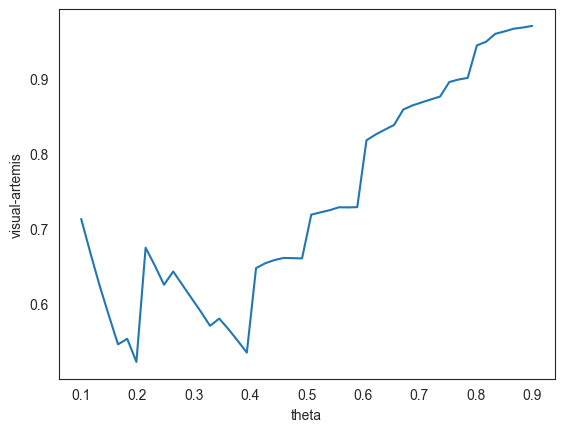

In [19]:
df = pandas.DataFrame({
    'theta': numpy.linspace(0.1, 0.9, 50),
    'visual-artemis': acc_th}
)
sns.set_style("white")
sns.lineplot(data=df, x="theta", y="visual-artemis", markers=True,
             err_style="bars", palette=["paleturquoise"], markersize=20)